### Calculate spatial maps, seasonal means

In [1]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
from utils import geo
import regionmask
from dask.diagnostics import ProgressBar
import glob
import pandas as pd
import os

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
dataset = 'globcolour-cmems'
frequency = 'day'
variable = 'CHL1'
yearstart = 1999
yearend = 2022
monthorder = 'DJF'
averaging = 'mean-time'

In [4]:
rootdir = '/projects/SOCCOM/datasets/GlobColour/'
local = 'CMEMS/OCEANCOLOUR_GLO_BGC_L4_MY_009_104-TDS/SouthernOcean_30Sto65S/'+frequency+'/bymonth/'
filename = 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_*.nc'
    
def preprocess(ds):
    time = pd.to_datetime(ds.attrs['start_time'])
    # This is a hack because of issues with data download
    ds = ds.where(ds['time.month']==ds['time.month'][0],drop=True).rename({'CHL':variable})
    return ds.copy()

print('Opening.')
paths = glob.glob(rootdir+local+filename)
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = xr.open_mfdataset(paths,preprocess=preprocess,use_cftime=False)
ds['time'] = pd.to_datetime(ds['time'].values)
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,axes_dims_dict={'X':'lon','Y':'lat'},periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

Opening.


In [5]:
# Apply a landmask
mask = regionmask.defined_regions.natural_earth.land_110.mask(ds['lon'], ds['lat'])
mask = mask.where(np.isfinite(mask),1)
mask = mask.where(mask==1,np.nan)
# Set unseen ocean to 0 and land to nan
ds[variable] = ds[variable].fillna(0)*mask

/home/graemem/.conda/envs/core/lib/python3.10/site-packages/regionmask/defined_regions/_natural_earth.py:471: FutureWarning: ``regionmask.defined_regions.natural_earth`` is deprecated. Please use ``regionmask.defined_regions.natural_earth_v4_1_0`` or ``regionmask.defined_regions.natural_earth_v5_0_0`` instead.
  warnings.warn(


In [11]:
ds = ds.chunk({'time':-1,'lon':round(len(ds['lon'])/(2**8)),'lat':round(len(ds['lat'])/(2**4))})
ds

,Array,Chunk
Bytes,249.09 GiB,63.26 MiB
Shape,"(9202, 841, 8640)","(9202, 53, 34)"
Count,54039 Tasks,4080 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,498.18 GiB,126.51 MiB
Shape,"(9202, 841, 8640)","(9202, 53, 34)"
Count,55256 Tasks,4080 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [12]:
# Calculate DJF climatology 
djf_clim = ds[variable].sel(time=slice(str(yearstart),str(yearend+1))).groupby('time.season').mean('time').sel(season='DJF')

In [13]:
outdir = '../../data/'
yearstr = str(yearstart)+'-'+str(yearend)
outpath = outdir+'.'.join([dataset,frequency,averaging,monthorder,yearstr,'nc'])

In [14]:
outpath

'../../data/globcolour-cmems.day.mean-time.DJF.1999-2022.nc'

In [ ]:
print('Saving to '+outpath)
if os.path.isfile(outpath):
    os.remove(outpath)
with ProgressBar():
    djf_clim.to_netcdf(outpath)

Saving to ../../data/globcolour-cmems.day.mean-time.DJF.1999-2022.nc
[                                        ] | 0% Completed | 26.46 sms

In [34]:
ds2021 = ds.sel(time=slice('2020-12-01','2021-02-28')).mean('time')

In [35]:
anom = ds2021-clim

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


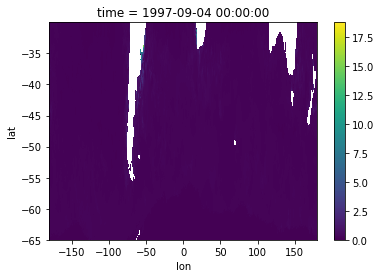

In [9]:
ds['CHL'].coarsen({'lon':4,'lat':4}).mean().isel(time=0).plot()